In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast
import warnings

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

TR_INPUT = 10
TR_OUTPUT = 3

tr_normalized = tr_norm_df.values
test_normalized = test_norm_df.values
training_set = tr_df.values
test_set = test_df.values

scaler_out = StandardScaler()
scaler_out.fit(training_set[:,TR_INPUT:])

training_len = len(tr_norm_df)
test_len = len(test_norm_df)

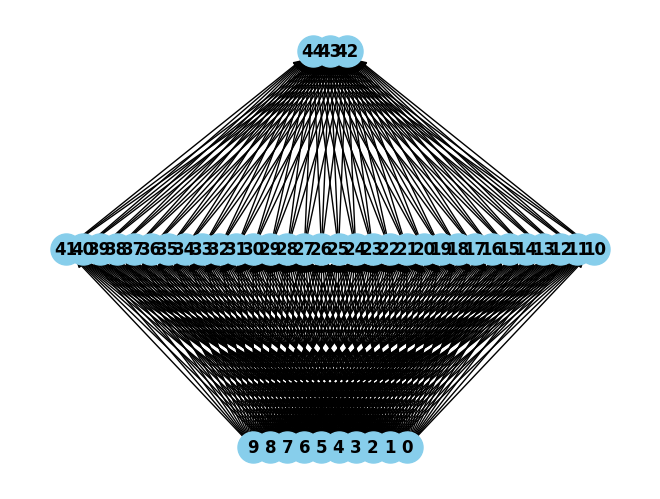

In [3]:
hidden_len = 32
hidden_fun = 'sigmoid'
output_fun = 'identity'
sigmoid_l1 = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)
NeuralNetwork.display_topology(sigmoid_l1)

In [4]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [5]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [6]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [7]:
results_files = ['bagging_model.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)

In [8]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [9]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [10]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [12]:
orig_df

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,"{'adamax': False, 'retrainig_es_error': -1.2, ...",8,150,500,5,0.000001,1.000000e-09,0.09,0.92,185,False,0.100152,0.013871,0.000011,3.661218e-07,0.009402


In [20]:
def get_new_tr_vl(pattern_set, len_ds, gen):

    return gen.choice(tr_normalized, len_ds)

In [31]:
gen = numpy.random.default_rng(seed=123)

In [37]:
n_models = 2
tr_len = 533
mod = []
for i in range(n_models):
    
    tr = get_new_tr_vl(tr_normalized[:533], 533, gen)
    NN = NeuralNetwork(sigmoid_l1, -0.75, 0.75, True, i + RANDOM_STATE)
    stats = NN.train(training_set =tr, 
                    validation_set = tr_normalized[-533:], 
                    
                    batch_size= 8, 
                    max_epochs= 500, 
                    min_epochs= 150,
                    retrainig_es_error = orig_df.iloc[0]['mean_best_validation_training_error'],
                    patience = 5, 
                    error_increase_tolerance = 0.000001, 
                    
                    lambda_tikhonov = 1.000000e-09, # off
                    
                    adamax = False,
                    
                    learning_rate = 0.09/8,
                    lr_decay_tau = 185, # off
                    eta_tau= 0.09*0.01,
                    alpha_momentum = 0.92, # off
                    nesterov = False,
                    
                    metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ], 
                    collect_data=True, 
                    collect_data_batch=False, 
                    verbose=True)
    mod.append([NN, stats])
    with open('../data/net/models_6_ens', 'w+') as file:
            file.write(NN.toJSON())


starting values:  {'training_set_len': 533, 'minibatch_size': 8, 'max_epochs': 500, 'retrainig_es_error': 0.01128271176549576, 'error_increase_tolerance': 1e-06, 'patience': 5, 'min_epochs': 150, 'learning_rate': 0.01125, 'lr_decay_tau': 185, 'eta_tau': 0.0009, 'lambda_tikhonov': 1e-09, 'alpha_momentum': 0.92, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.01, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999996), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'traini

IsADirectoryError: [Errno 21] Is a directory: '../data/net/models_6_ens'

In [ ]:
interesting_model = load_obj('../data/net/models_5_gs_fg/models.json')

In [ ]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_mean_euclidean_error','validation_mean_euclidean_error']
    cols_name = ['tmse','vmse','tmee','vmee']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    return x
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

In [ ]:
df_im

,nn_file_name,index,model,top_name,std_prediction_tr,std_prediction_val,std_prediction_test,prediction_tr,prediction_val,prediction_test,std_tr_error,std_val_error,tr_error,val_error,tmse,vmse,tmee,vmee
0,../data/net/models_3_gs/32_tanh_0.json,0,id: 41 w: [-0.12769051 -0.1884113 0.25677923...,32_tanh,[[ 0.38482902 1.04123932 -1.23160675]\n [ 0.7...,[[ 5.60075362e-01 -2.93809450e-01 1.48644619e...,[[ 9.47073094e-01 -8.57045888e-01 1.16338728e...,[[ -1.15436511 14.39977269 4.73903078]\n [ ...,[[ 3.40665646e+00 -2.45115537e+01 3.25365636e...,[[ 1.34787922e+01 -4.09276407e+01 2.92326395e...,0.265221,0.261672,5.551601,5.547372,"[0.7164744283287965, 0.3274523521789889, 0.223...","[0.7935127012133883, 0.36590658047832, 0.24886...","[0.7764827090351548, 0.5183929916951465, 0.424...","[0.8250849415160474, 0.5487858749194781, 0.445..."


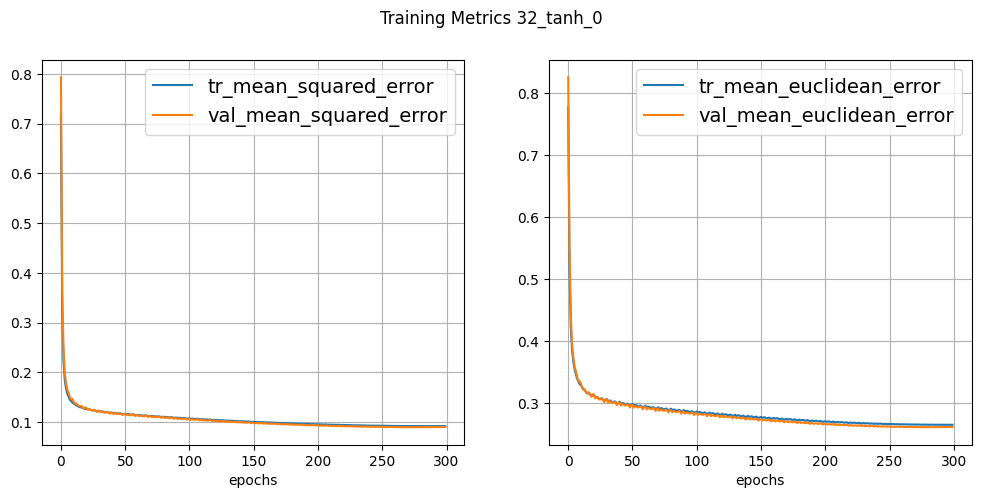

In [ ]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(12, 5))
    plt.suptitle('Training Metrics ' + dummy['top_name'] + '_' + str(dummy['index']))
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['tr_' + metrics[i].__name__, 'val_' + metrics[i].__name__],
                ax=ax[i])

In [ ]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['validation_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_mean_euclidean_error']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['validation_mean_euclidean_error']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()

In [ ]:
'''for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights')'''

"for unit_index in stats['units_weights'].keys():\n    vals = np.array(stats['units_weights'][unit_index]).T\n    multy_plot(vals, \n               ['weight_' + str(i) for i in range(len(vals))], \n               'Unit ' + str(unit_index) + ' Weights')"